### Подключим необходимые библиотеки

In [2]:
from sklearn.preprocessing import FunctionTransformer

from reskit.norms import binar_norm, wbysqdist
from reskit.norms import spectral_norm

from reskit.features import degrees,  pagerank

from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier 
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from reskit.core import Transformer, Pipeliner

import os
import pandas as pd
import numpy as np
import copy

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def orig(x):
    return x

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io
import scipy.sparse
import scipy.stats
from scipy import interp
import time
import networkx as nx
import sys
import igraph as ig

In [4]:
import matrix_eig as me

### Функция считывания данных

In [5]:
def get_autism(path_to_read='Data/dti/', distances=True):
    def get_autism_distances(loc_name):
        with open(loc_name, 'r') as f:
            read_data = f.readlines()

        read_data = pd.DataFrame(
            np.array([np.array(item[:-1].split()).astype(int) for item in read_data]))

        return read_data

    def get_distance_matrix(coords):
        if type(coords) == pd.core.frame.DataFrame:
            coords = coords.values
        elif type(coords) != np.ndarray:
            print('Provide either pandas df or numpy array!')
            return -1

        shape = len(coords)
        dist_matrix = np.zeros((shape, shape))
        del shape
        for i in range(len(coords)):
            for j in range(i + 1, len(coords)):
                dist_matrix[i, j] = np.linalg.norm(coords[i, :] - coords[j, :])
                dist_matrix[j, i] = dist_matrix[i, j]
        return dist_matrix

    target_vector = []  # this will be a target vector (diagnosis)
    matrices = []  # this will be a list of connectomes
    all_files = sorted(os.listdir(path_to_read))
    matrix_files = [
        item for item in all_files if 'DTI_connectivity' in item and 'All' not in item]
    distance_files = [
        item for item in all_files if 'DTI_region_xyz_centers' in item and 'All' not in item]

    # for each file in a sorted (!) list of files:
    for filename in matrix_files:

        A_dataframe = pd.read_csv(
            path_to_read + filename, sep='   ', header=None, engine='python')
        A = A_dataframe.values  # we will use a list of numpy arrays, NOT pandas dataframes
        matrices.append(A)# append a matrix to our list
        if "ASD" in filename:
            target_vector.append(1)
        elif "TD" in filename:
            target_vector.append(0)
    asd_dict = {}
    asd_dict['X'] = np.array(matrices)
    asd_dict['y'] = np.array(target_vector)
    if distances:
        dist_matrix_list = []
        for item in distance_files:
            # print(item)
            cur_coord = get_autism_distances(path_to_read + item)
            cur_dist_mtx = get_distance_matrix(cur_coord)
            dist_matrix_list += [cur_dist_mtx]

        asd_dict['dist'] = np.array(dist_matrix_list)

    return asd_dict


## Посмотрим на один граф ваочию

In [6]:
path = 'Data/dti/'
data = get_autism(path)

In [7]:
X = data['X']
y = data['y'] 
print X.shape, y.shape

(94, 264, 264) (94,)


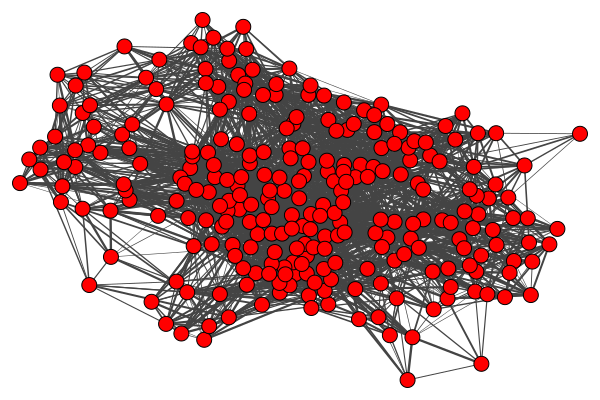

In [8]:
A = X[0]
G = ig.Graph.Weighted_Adjacency(list(A), mode="UNDIRECTED", attr="weight", loops=False)

visual_style = {}
visual_style["vertex_size"] = 15
visual_style["bbox"] = (600, 400)
visual_style["margin"] = 20
visual_style["edge_width"] = [ 0.1 * i for i in range(5, 25)]
ig.plot(G, **visual_style)

## Произведем зашумление данных

Выберем рандомное ребро с весом $w$. После чего надо добавить к нему $w'$, которое будет браться из нормального распределения $N(w, 1)$

In [9]:
import random

In [10]:
def noise_matrix(data, num_noise = 10, sigma = 1):
    list_of_matrices = data['X']
    list_of_predict  = data['y']
    
    shape = list_of_matrices.shape
    loc1 = random.randint(0, shape[0] - 1)
    X_new = copy.copy(list_of_matrices[loc1])
    y_new = copy.copy(list_of_predict[loc1])
    y_new = np.array(y_new)
    y_new = y_new.reshape(1, )
    for i in range(num_noise):
        loc2 = random.randint(0, shape[1] - 1), random.randint(0, shape[2] - 1)
        loc2_inv = loc2[1], loc2[0]
        loc = loc1, loc2[0], loc2[1]
        w = list_of_matrices[loc]
        if (w != 0):
            X_new[loc2] = random.normalvariate(w, sigma)
            X_new[loc2_inv] = X_new[loc2]
        else:
            X_new[loc2] = abs(random.normalvariate(w, sigma))
            X_new[loc2_inv] = X_new[loc2]
    
    X_new = np.array([X_new])
    list_of_matrices = np.vstack([list_of_matrices, X_new])
    list_of_predict = np.hstack([list_of_predict, y_new])
    
    data['X'] = list_of_matrices
    data['y'] = list_of_predict
    
    #print loc1, loc2, X_new
    return data

## Разделим данные

Разделим все данные на две части (70% - данные для обучения, 30% - проверочная выборка). Проблема заключается в том, что данных мало (~100), и для обучения оставшихся данных слишком мало. Классификатор может переобучиться или, что более логично, недообучиться. Тогда попробуем зашумить данные эти данные, чтобы иметь больше данных для обучения. После чего проверим, на сколько хорошо мы обучились на оставшейся выборке. 

In [11]:
from sklearn.cross_validation import train_test_split

In [12]:
(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, test_size=0.3, random_state=0)

In [54]:
data_train = {}
data_train['X'] = X_train
data_train['y'] = y_train

data_test = {}
data_test['X'] = X_test
data_test['y'] = y_test

In [55]:
for i in range(30):
    noise_matrix(data_train, num_noise=20, sigma = 2)

In [66]:
def get_train(path_to_read = 'Bluh-bluh'):
    return data_train

def get_test(path_to_read = 'Bluh-bluh'):
    return data_test

def get_data(path_to_read = 'Bluh-bluh'):
    return data

## Обучим лог регрессию

In [16]:
def orig_vec(data):
    matrix = []
    for i in  data['X']:
        matrix.append(np.hstack(i))
    data['X_vec'] = np.array(matrix)
    return data

In [17]:
grid_cv = StratifiedKFold(n_splits=10,
                          shuffle=True,
                          random_state=0)

eval_cv = StratifiedKFold(n_splits=10,
                          shuffle=True,
                          random_state=1)

In [60]:
new_data = Transformer(get_train).fit_transform(data)
new_data = Transformer(degrees, collect=['degrees']).fit_transform(new_data)
X_fit, y_fit = new_data
print X_fit.shape, y_fit.shape

(95, 264) (95,)


In [61]:
steps = [('selector', VarianceThreshold()), ('scaler', MinMaxScaler()), ('classifier', LogisticRegression())] 
pipeline = Pipeline(steps)

In [62]:
param_grid = dict(classifier__penalty=['l1', 'l2'], classifier__max_iter = [50, 100],
                  classifier__C = [0.1, 0.25, 0.5, 0.75, 1.0])

scoring = 'roc_auc'
grid_clf = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring=scoring, n_jobs=-1, cv=grid_cv)
grid_clf.fit(X_fit, y_fit)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
       error_score='raise',
       estimator=Pipeline(steps=[('selector', VarianceThreshold(threshold=0.0)), ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'classifier__max_iter': [50, 100], 'classifier__C': [0.1, 0.25, 0.5, 0.75, 1.0], 'classifier__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [63]:
steps[-1] = steps[-1][0], grid_clf.best_estimator_
pipeline = Pipeline(steps)
scores = cross_val_score(pipeline, X_fit, y_fit, scoring=scoring, cv=eval_cv, n_jobs=-1)
np.mean(scores), np.std(scores)

(0.84416666666666684, 0.12791327357063284)

In [69]:
new_data = Transformer(get_test).fit_transform(data)
new_data = Transformer(degrees, collect=['degrees']).fit_transform(new_data)
X_score, y_score = new_data
print X_score.shape, y_score.shape

(29, 264) (29,)


In [70]:
steps[-1] = steps[-1][0], grid_clf.best_estimator_
pipeline = Pipeline(steps)
scores = cross_val_score(pipeline, X_score, y_score, scoring=scoring, cv=eval_cv, n_jobs=-1)
np.mean(scores), np.std(scores)

(0.65000000000000002, 0.39051248379533277)